In [ ]:
# ------------------------Mental Health Classification using NLP and Machine Learning---------------------------

In [17]:
# loading the dataset

import pandas as pd
df = pd.read_csv("Combined Data.csv")

# df.head() displays first 5 rows to understand structure.
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
# df.info() → checks data types, missing values.
# value_counts() → checks distribution of mental health categories.

# This helps identify imbalance in dataset.
df.info()
df['status'].value_counts()


<class 'pandas.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  53043 non-null  int64
 1   statement   52681 non-null  str  
 2   status      53043 non-null  str  
dtypes: int64(1), str(2)
memory usage: 1.2 MB


status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

In [3]:
# cleaning the dataset
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    return text

df['clean_statement'] = df['statement'].apply(clean_text)


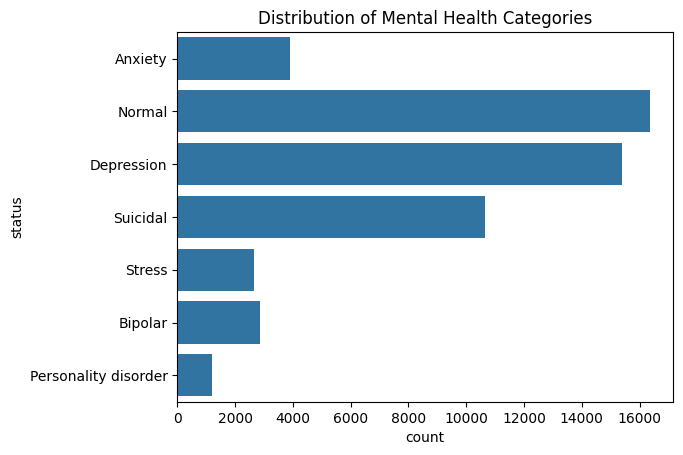

In [ ]:
# first visualization-Class Distribution

# Shows how many samples per category.
# Helps detect class imbalance.

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(y='status', data=df)
plt.title("Distribution of Mental Health Categories")
plt.show()


In [5]:
# dropping the useless and missing data values
df.drop(columns=['Unnamed: 0'], inplace=True)
df = df.dropna(subset=['statement'])
df.info()

<class 'pandas.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   statement        52681 non-null  str  
 1   status           52681 non-null  str  
 2   clean_statement  52681 non-null  str  
dtypes: str(3)
memory usage: 1.6 MB


In [ ]:
# Sentiment Analysis using TextBlob
# ------------------------sentimental score-----------------
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment_score'] = df['clean_statement'].apply(get_sentiment)

# Returns polarity score between:

# -1 (very negative)

# 0 (neutral)

+1 (very positive)


In [ ]:
# coverting the sentimental score into label
# Why ±0.05?
# To avoid labeling very small fluctuations as positive/negative.

def sentiment_label(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['sentiment_score'].apply(sentiment_label)


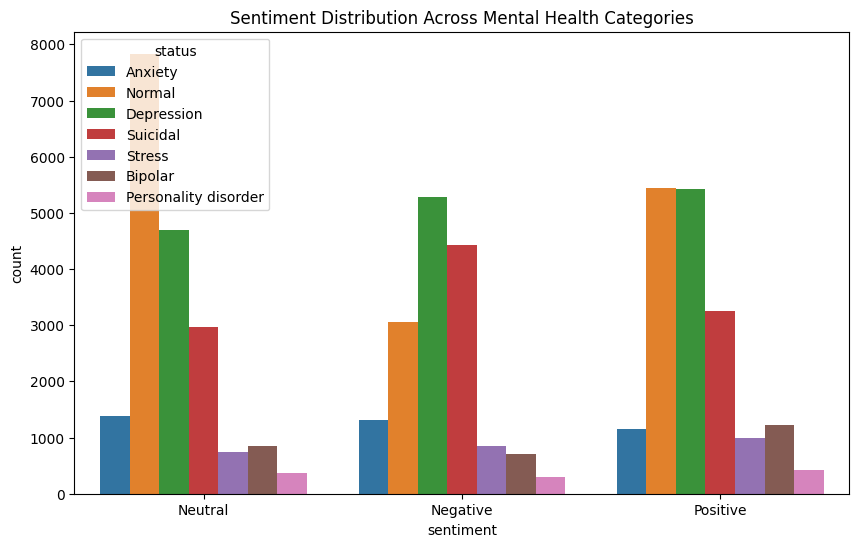

In [8]:
# Visualizing Sentiment vs Mental Health Status
plt.figure(figsize=(10,6))
sns.countplot(x='sentiment', hue='status', data=df)
plt.title("Sentiment Distribution Across Mental Health Categories")
plt.xticks(rotation=0)
plt.show()


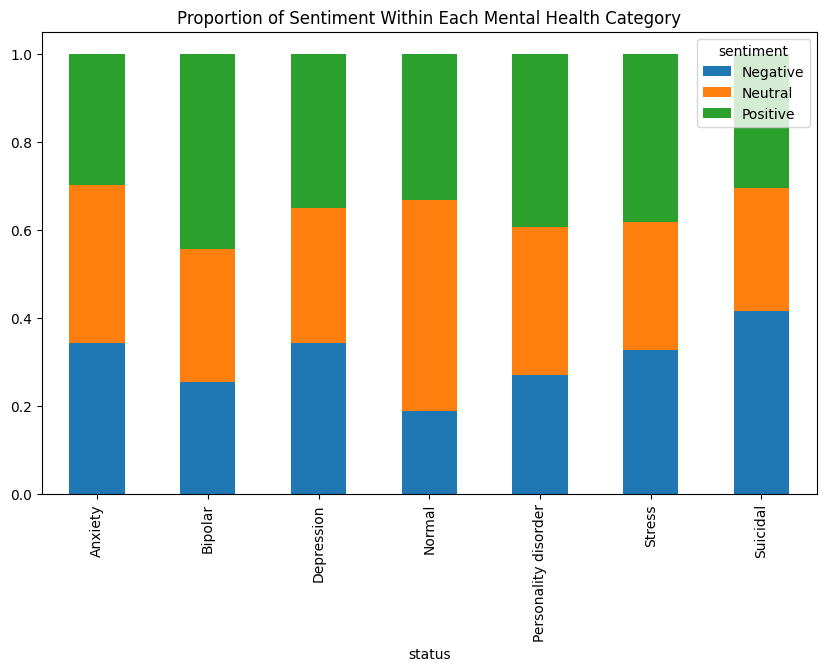

In [ ]:
# normalizing the sentimental view
sentiment_status = pd.crosstab(df['status'], df['sentiment'], normalize='index')
sentiment_status.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Proportion of Sentiment Within Each Mental Health Category")
plt.show()

# Normalized Proportion Plot

In [ ]:
#---------------- Now i will create "WORD CLOUDS PER MENTAL HEALTH CATEGORY"--------------------

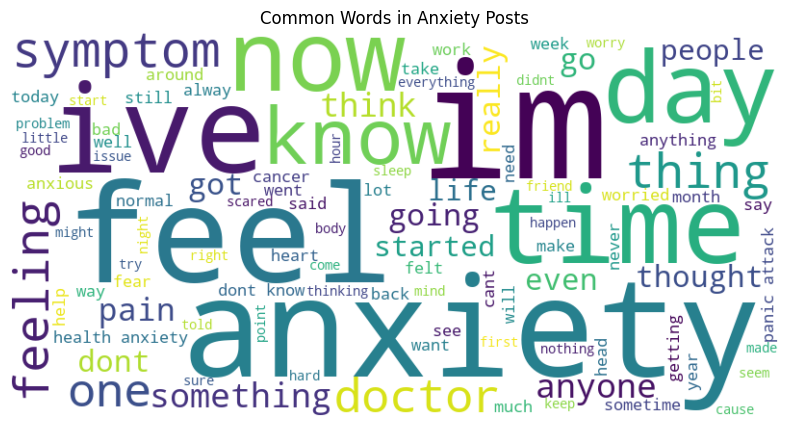

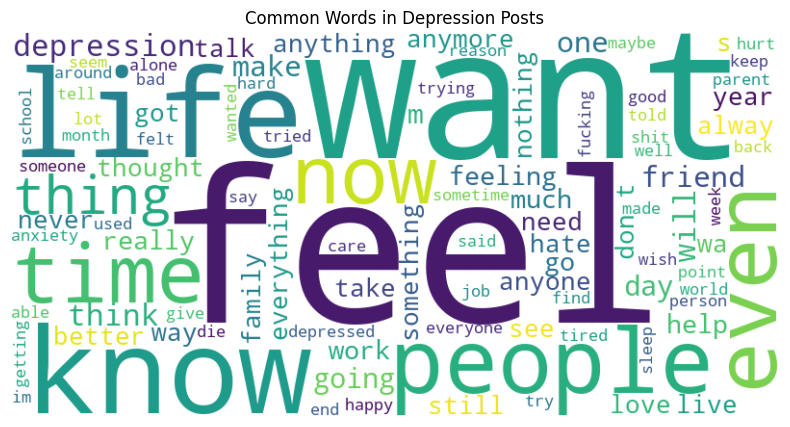

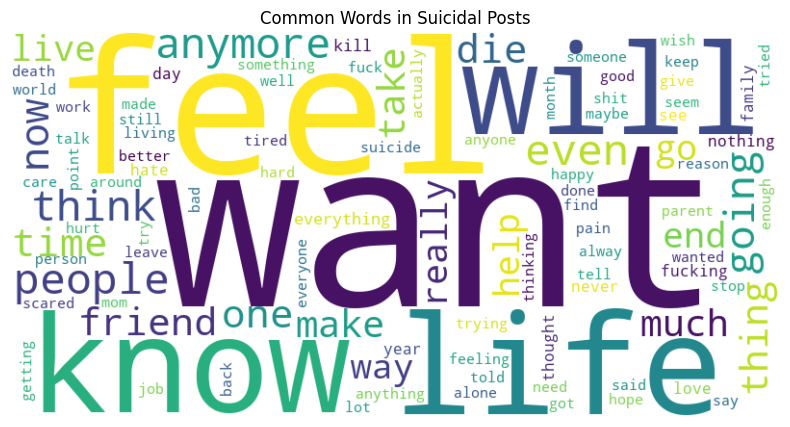

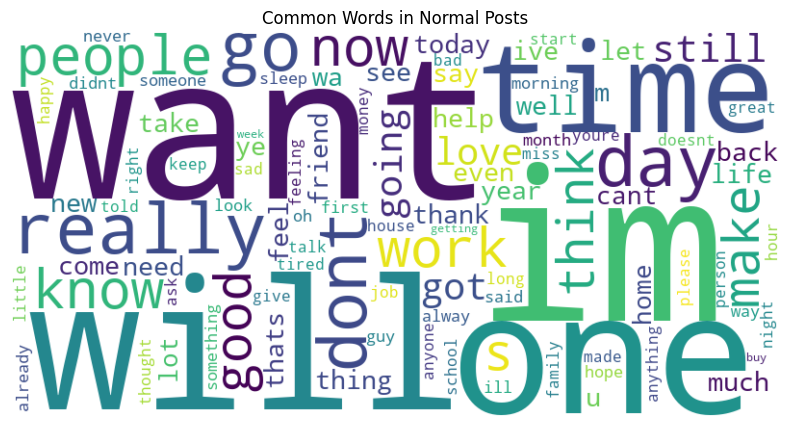

In [10]:
from wordcloud import WordCloud

def plot_wordcloud(category):
    text = " ".join(
        df[df['status'] == category]['clean_statement']
        .dropna()
    )

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100
    ).generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Common Words in {category} Posts")
    plt.show()

# generating four key categories
plot_wordcloud("Anxiety")
plot_wordcloud("Depression")
plot_wordcloud("Suicidal")
plot_wordcloud("Normal")



In [ ]:
# ------------------------ Language Analysis using TF-IDF--------------------

Accuracy: 0.7605580335959001

Classification Report:

                      precision    recall  f1-score   support

             Anxiety       0.79      0.80      0.79       768
             Bipolar       0.75      0.80      0.77       556
          Depression       0.80      0.63      0.70      3081
              Normal       0.87      0.90      0.89      3269
Personality disorder       0.50      0.76      0.60       215
              Stress       0.49      0.68      0.57       517
            Suicidal       0.67      0.73      0.70      2131

            accuracy                           0.76     10537
           macro avg       0.69      0.76      0.72     10537
        weighted avg       0.77      0.76      0.76     10537



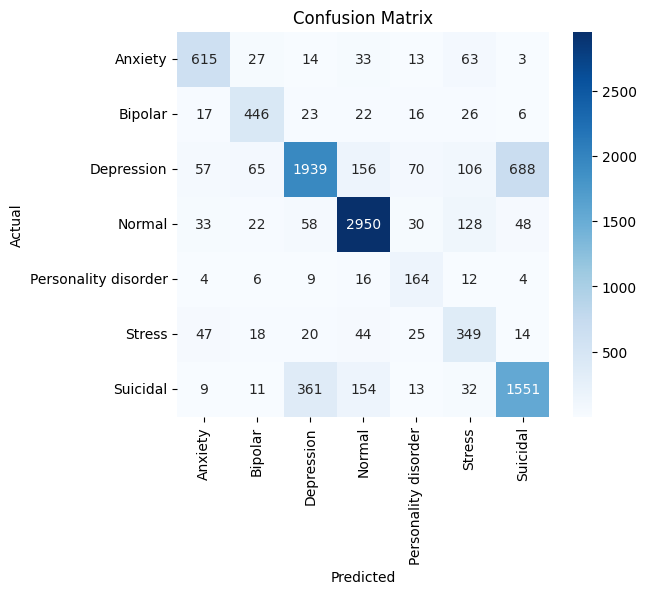

In [ ]:
# Machine Learning Section

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Features and target
X = df['clean_statement']
y = df['status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english'
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression
# model = LogisticRegression(max_iter=1000)
model = LogisticRegression(max_iter=1000, class_weight='balanced')

model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model.predict(X_test_tfidf)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Interpreting Important Words
feature_names = vectorizer.get_feature_names_out()

for i, class_label in enumerate(model.classes_):
    top10 = model.coef_[i].argsort()[-10:]
    print(f"\nTop words for {class_label}:")
    print([feature_names[j] for j in top10])

# Extracts top 10 highest-weighted words for each category.
# Shows which words strongly influence classification.
# Adds interpretability to model.


Top words for Anxiety:
['symptoms', 'restlessness', 'health', 'cancer', 'worry', 'nervous', 'worried', 'anxious', 'restless', 'anxiety']

Top words for Bipolar:
['hypomania', 'lithium', 'lamictal', 'hypomanic', 'bp', 'meds', 'mania', 'episode', 'manic', 'bipolar']

Top words for Depression:
['doe', 'ha', 'http', 'pression', 'anymore', 'don', 'wa', 've', 'depressed', 'depression']

Top words for Normal:
['lets', 'ptsd', 'twitter', 'com', 'eid', 've', 'yes', 'url', 'don', 'wa']

Top words for Personality disorder:
['im', 'dont', 'pretend', 'shame', 'people', 'interaction', 'social', 'poll', 'avoidant', 'avpd']

Top words for Stress:
['stressful', 'situation', 'abuse', 'im', 'ive', 'anxiety', 'ptsd', 'stressed', 'tldr', 'stress']

Top words for Suicidal:
['gun', 'goodbye', 'end', 'want', 'rt', 'anymore', 'die', 'kill', 'suicide', 'suicidal']


In [ ]:
# -------------------------------
# Final Conclusion
# -------------------------------

# This project demonstrates how Natural Language Processing
# and Machine Learning can be used to classify mental health
# conditions based on textual statements.

# Logistic Regression with TF-IDF features performed effectively,
# especially after handling class imbalance.

# Future improvements could include:
# - Using advanced models like Naive Bayes or SVM
# - Trying deep learning models (LSTM, BERT)
# - Deploying as a web application

